# Project Kojak - Crunchbase
### Daniel Shin


## Imports

In [1]:
# API
from pycrunchbase import *

# Python
import datetime
from collections import Counter
import pandas as pd
import numpy as np
from scipy import sparse
import re
import json
from urllib2 import urlopen
import string

# Database
from pymongo import MongoClient

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import tokenize
from nltk.stem import PorterStemmer


# Machine learning
from sklearn.preprocessing import Imputer
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import tokenize
from sklearn import preprocessing
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import IncrementalPCA
import lshash
client = MongoClient()

## Load Data

In [2]:
# MONGODB
# initialize and access a kojak database and collection

db = client.kojak
crunch_ppl = db.crunch_ppl
orgs_api = db.orgs_api

In [3]:
# PYCRUNCHBASE
# use pycrunchbase wrapper to access crunchbase API using key

cb_api_key = "f724cd5232dd318067da50fd13ec28bc"
cb = CrunchBase(cb_api_key)

In [4]:
# OPEN DATA MAP
# read in data from open data map

orgs_odm_df = pd.read_csv("/Users/DanShin/Downloads/Data/odm/organizations.csv")
ppl_odm_df = pd.read_csv("/Users/DanShin/Downloads/Data/odm/people.csv")

In [4]:
# load in tabs of crunchbase_export.xls file as different dataframes
# companies (companies and aggregated funding information)
# rounds (summarized version of investments for each round - can disregard and just use investments)
# investments (info on company, their investments, funding round, amount raised)
# acquisitions (info on company, their acquirer, the price amount and currency)

companies = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Companies")
# rounds = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Rounds")
# investments = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Investments")
# acquisitions = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Acquisitions")

## Preprocess

In [6]:
# preprocess data

orgs_odm_df = orgs_odm_df.drop("type", axis = 1)
orgs_odm_df = orgs_odm_df.drop("profile_image_url", axis = 1)

ppl_odm_df = ppl_odm_df.drop("type", axis = 1)
ppl_odm_df["name"] = ppl_odm_df.first_name + " " + ppl_odm_df.last_name

# combine names and insert to index 1
ppl_odm_df = ppl_odm_df.drop(["first_name", "last_name"], axis = 1)
columns = ppl_odm_df.columns.tolist()
columns.remove("name")
columns.insert(1, "name")
ppl_odm_df  = ppl_odm_df[columns]
ppl_odm_df = ppl_odm_df.drop("profile_image_url", axis = 1)

In [5]:
# find most common markets represented

top_categories = Counter(companies.market).most_common(4)
top_categories = [x[0] for x in top_categories]

In [30]:
top_categories

[u'Software', u'Biotechnology', u'Mobile', u'E-Commerce']

In [24]:
comps_subset = investments[investments.company_market.isin(top_categories)]

In [16]:
market = top_categories[0][0]
num_per_round = Counter(investments.funding_round_code[investments.company_market == market])
fund_round_counts = num_per_round.items()
fund_round_counts = [x for x in fund_round_counts if type(x[0]) == unicode]  # remove nans
fund_rounds = [str(r[0]) for r in fund_round_counts]
fund_counts = [r[1] for r in fund_round_counts]

In [22]:
fund_counts

[2766, 1259, 2235, 217, 671, 14, 52]

In [4]:
def clean_companies(companies_df):
    # convert erroneous datetimes to NaT
    companies_df.first_funding_at = companies_df.first_funding_at.apply(lambda x: np.nan if type(x) == unicode else x)
    # convert permalink format to integrate with API
    companies_df.permalink = companies_df.permalink.apply(lambda x: x.replace("/organization", "organizations"))
    # convert erroneus datetimes to NaT
    companies_df.founded_at = companies_df.founded_at.apply(lambda x: np.nan if type(x) == unicode else x)
    return companies_df

companies = clean_companies(companies)

## Visualize Data

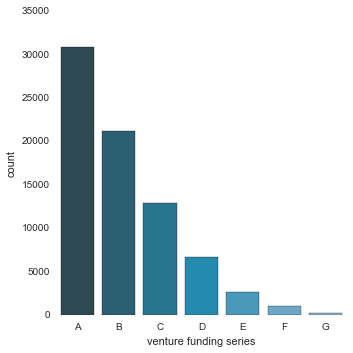

In [35]:
# histogram of all venture funding rounds

total_fund_rounds = sns.factorplot("funding_round_code", data=investments, x_order=list("ABCDEFG"), palette="PuBuGn_d");
total_fund_rounds.set_axis_labels("venture funding series")

plt.savefig("total_invest_rounds.png")

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


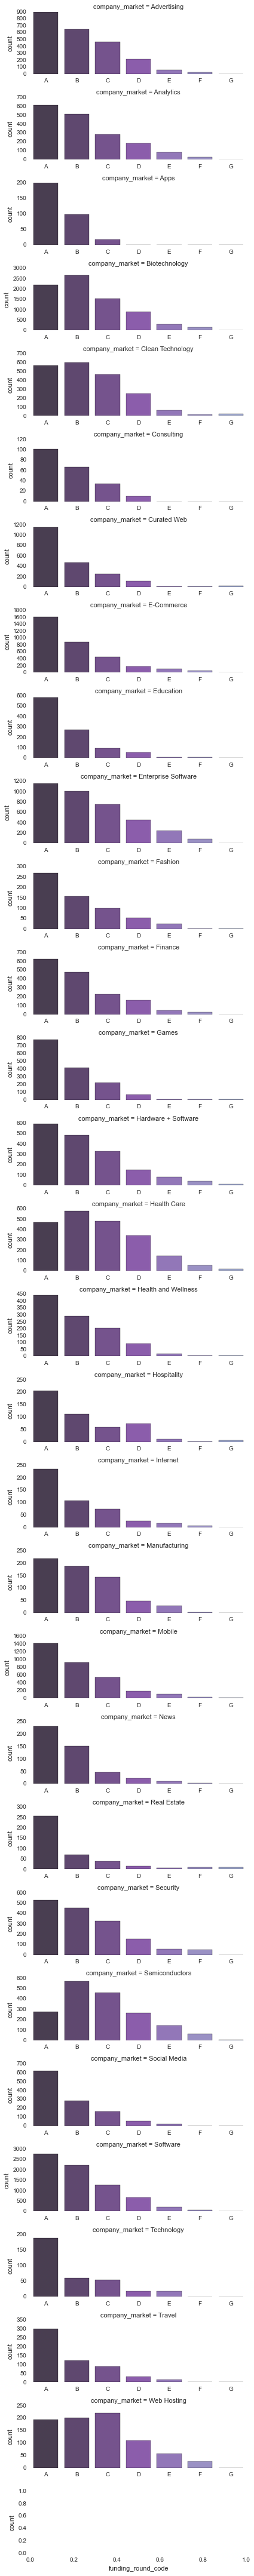

In [32]:
# identify 30 common categories
top_categories = Counter(companies.market).most_common(30)
top_categories = [x[0] for x in top_categories]
                  
# investment info for only companies in 30 most common categories
comps_subset = investments[investments.company_market.isin(top_categories)]

# histogram of venture funding rounds by market
sns.factorplot("funding_round_code", data=comps_subset, row="company_market", x_order=list("ABCDEFG"),
               margin_titles=False, aspect=3, size=2, palette="BuPu_d", sharex = False, sharey = False);

In [36]:
# show percent of companies operating, acquired, IPO, closed

def get_status_pct(companies):
    tot_companies = float(companies.status.shape[0])
    num_operating = sum(companies.status == "operating")/tot_companies
    num_acquired = sum(companies.status == "acquired")/tot_companies
    num_ipo = sum(companies.status == "ipo")/tot_companies
    num_closed = sum(companies.status == "closed")/tot_companies
    
    print "Total Percent Operating: " + str(round(num_operating * 100, 1)) + "%"
    print "Total Percent IPO: " + str(round(num_acquired * 100, 1)) + "%"
    print "Total Percent Acquired: " + str(round(num_ipo * 100, 1)) + "%"
    print "Total Percent Closed: " + str(round(num_closed * 100, 1)) + "%"

get_status_pct(companies)

Total Percent Operating: 82.6%
Total Percent IPO: 7.5%
Total Percent Acquired: 2.5%
Total Percent Closed: 5.3%


In [37]:
# get average number of funding rounds for status group

def get_avg_rounds(companies):
    avg_rounds_operating = np.mean(companies[companies.status == "operating"].funding_rounds)
    avg_rounds_ipo = np.mean(companies[companies.status == "ipo"].funding_rounds)
    avg_rounds_acquired = np.mean(companies[companies.status == "acquired"].funding_rounds)
    avg_rounds_closed = np.mean(companies[companies.status == "closed"].funding_rounds)

    print "Average Num Rounds Operating: " + str(round(avg_rounds_operating, 2))
    print "Average Num Rounds IPO: " + str(round(avg_rounds_ipo, 2))
    print "Average Num Rounds Acquired: " + str(round(avg_rounds_acquired, 2))
    print "Average Num Rounds Closed: " + str(round(avg_rounds_closed, 2))
    
get_avg_rounds(companies)

Average Num Rounds Operating: 1.67
Average Num Rounds IPO: 2.68
Average Num Rounds Acquired: 2.05
Average Num Rounds Closed: 1.49


In [38]:
# from companies that have IPO'd get 

Counter(companies[companies.status == "ipo"].market).most_common(10)

[(u'Biotechnology', 422),
 (u'Software', 93),
 (u'Health Care', 63),
 (u'Clean Technology', 49),
 (u'Hardware + Software', 46),
 (u'Mobile', 41),
 (u'E-Commerce', 36),
 (u'Semiconductors', 35),
 (u'Curated Web', 26),
 (u'Manufacturing', 26)]

Early stage startups: which ones affect your growth.
Try to find out what makes early stage startups successful and categorize them.
What are the characteristics of each startup or fund?
Do a vertical barplot for each industry, broken down by percent of funding in each category.
Do an analysis of raised_amount_usd by funded_year
Do an analysis of raised_amount_usd by funded_month
Do an analysis of average time to IPO/acquisition by year of exit
Investor market

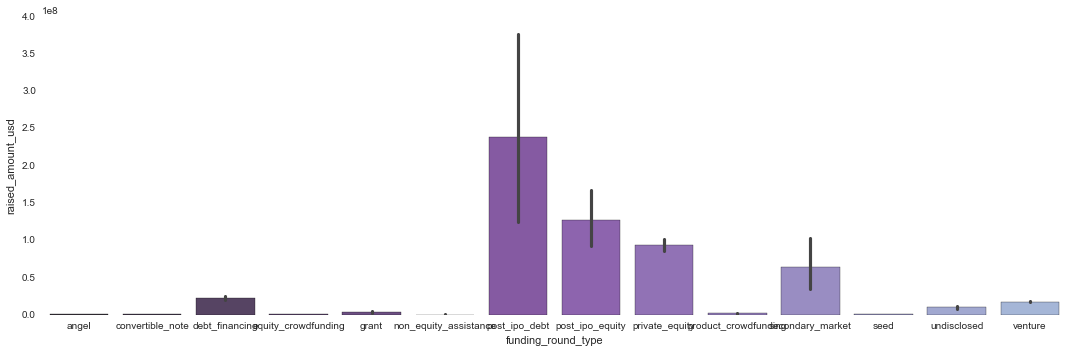

In [15]:
# plot of aggregated amount raised by funding_round_type

sns.factorplot("funding_round_type", "raised_amount_usd", data=investments,
               margin_titles=False, aspect=3, size=5, palette="BuPu_d", sharex = False, sharey = False);

In [16]:
# aggregated view of type of funding rounds

Counter(investments.funding_round_type)

Counter({u'venture': 97456, u'seed': 47069, u'angel': 6792, u'undisclosed': 5847, u'debt_financing': 3351, u'private_equity': 2658, u'convertible_note': 1713, u'grant': 1514, u'equity_crowdfunding': 1421, u'post_ipo_equity': 446, u'product_crowdfunding': 150, u'non_equity_assistance': 148, u'post_ipo_debt': 140, u'secondary_market': 98})

In [22]:
# Total price of acquisitions by year - Going up (big spike in 2014)

acquisitions.groupby("acquired_year").sum().plot(kind = "bar")

NameError: name 'acquisitions' is not defined

In [17]:
# total funding rounds for acquired companies

Counter(companies[companies.status == "acquired"].funding_rounds)

Counter({1: 2107, 2: 1026, 3: 591, 4: 284, 5: 139, 6: 82, 7: 40, 8: 13, 9: 10, 10: 5, 11: 4, 15: 1})

In [ ]:
# for company in companies.permalink:
#     comp_name = company[14:]
#     try:
#         comp_api = cb.organization(comp_name)
#     except:
#         print "Error: " + comp_name
#         continue
#     orgs_api.insert(comp_api.data)

Error: 1000jobboersen-de
0:02:03.860596
Error: 3d-systems
Error: 58-com
Error: 5barz-international
Error: a-power-energy-generation
Error: abattis-bioceuticals
Error: abbott
Error: ablynx
Error: accelera-innovations
Error: accelerize-new-media
Error: access-pharmaceuticals
Error: acco-brands
Error: acorn-international
Error: acs-global
Error: actinium-pharmaceuticals
Error: activenetwork
Error: acusphere
Error: adaptive-media
Error: adcare-health-systems
Error: adslinked
Error: advanced-media
Error: aeropostale
Error: affymax
Error: agenus
Error: airspan-networks
Error: airtouch-communications
Error: alere
Error: alldigital
Error: allon-therapeutics
Error: altigen-communications
Error: altran
Error: ambient-corporation
Error: ambow-education
Error: american-addiction-centers
Error: american-apperal
Error: american-cannabis-company
Error: american-restaurant-concepts
Error: ampio-pharmaceuticals
Error: ampliphi-biosciences
Error: anavex
Error: anda
Error: anesiva
Error: envirosystems-i

In [13]:
with open("errors.txt", "r") as f:
    errors = f.read()

In [18]:
company_errors = errors.replace("Error: ", "").split("\n")

In [70]:
# start where it was interrupted

for comp_name in company_errors:
    try:
        url = urlopen("https://api.crunchbase.com/v/3/organizations/" + comp_name + "?user_key=f724cd5232dd318067da50fd13ec28bc")
        data_string = url.read()
        json_file = json.loads(data_string)
    except:
        print "Error: " + comp_name
        continue
    orgs_api.insert(json_file["data"])

Error: 1000jobboersen-de
Error: adslinked
Error: asiansbook
Error: asktourism
Error: avis-2
Error: complex-media
Error: connect-hq
Error: contactpoint
Error: corenergy-infrastructure-trust
Error: corindus
Error: cormedix
Error: cortendo
Error: cortex-business-solutions
Error: crexendo
Error: shadowdcat-consulting
Error: freem?
Error: green-mountain-digital
Error: ?novatiff-reklam-ve-tan?t?m-hizmetleri-tic
Error: iproof---the-foundation-for-the-internet-of-things
Error: its-all-about-me
Error: klink-technologies
Error: knownact
Error: luma-legacy-2
Error: ob1-2
Error: on-the-run-tech
Error: patrof?n
Error: prod?ti-cz
Error: prze?wietl-pl
Error: socialchorus
Error: sociocast-networks
Error: soligenix
Error: somedia-bbn3
Error: spire-corporation
Error: spot-coffee
Error: spotlight-innovation
Error: sprylogics-international-corp
Error: talentsigned
Error: tutored-2
Error: vacation-bnb
Error: wavemaker-software
Error: whites-holdings
Error: whodats-spaces


In [24]:
total = orgs_api.count()
has_team = 0

for org in orgs_api.find():
    if "current_team" in org["relationships"]:
        has_team += 1
    
print float(has_team)/total

KeyError: 'relationships'

In [25]:
# extract school info from people

school = []
for entry in some_person.data["relationships"]["degrees"]["items"]:
    entry_nested = entry["relationships"]["school"]["properties"]["name"]
    school.append(entry_nested)

NameError: name 'some_person' is not defined

In [ ]:
stage = ["Seed", "Angel", "Series A", "Series B", "Series C", "Now"]
indexes = np.array([1,2,3,4,5])
amount = np.array([.325, .7, 4.7, 12, 14])

plt.figure(figsize = (10,3.5))

mint = sns.barplot(indexes, amount, palette="PuBuGn_d")
mint.set_ylim(0,15)
sns.set(font_scale = 2)
mint.set_title("Mint")

mint.set_ylabel("$ million funding")
mint.set_xticklabels(stage)
plt.tight_layout()
plt.savefig("Mint.png")

stage = ["Seed", "Series A", "", "", ""]
indexes = np.array([1,2,3,4,5])
amount = np.array([.7, 4, 0, 0, 0])

plt.figure(figsize = (10, 3.5))

wesabe = sns.barplot(indexes, amount, palette="PuBuGn_d")
wesabe.set_ylim(0,15)
sns.set(font_scale = 2)
wesabe.set_title("Wesabe")

wesabe.set_ylabel("$ million funding")
wesabe.set_xticklabels(stage)
plt.tight_layout()
plt.savefig("Wesabe.png")

## Build DataFrames

In [6]:
# get company names
def get_names(list_of_companies):
    names = list_of_companies.name
    return names

# get matrix with category of each company
def get_categories(list_of_companies):
    # preprocess category_list
    categories = list_of_companies.category_list
    categories[categories.isnull()] = ''
    categories = categories.str.replace(' ', '-')
    categories = categories.str.strip('|')
    categories = categories.apply(lambda x: x.replace("|", " "))
    # tokenize and vectorize
#     category_counts = CountVectorizer(tokenizer = tokenize.word_tokenize)
#     sparse_matrix = category_counts.fit_transform(categories)
    return categories

def get_market(list_of_companies):
    market = list_of_companies.market
    return market

def get_funding_rounds(list_of_companies):
    num_rounds = list_of_companies.funding_rounds
    return num_rounds

def get_funding_total(list_of_companies):
    # around 10,000 of 57,000 companies have 0 funding in the database???
    funding_total_usd = list_of_companies.funding_total_usd
    return funding_total_usd

def get_founded_year(list_of_companies):
    founded_year = list_of_companies.founded_year
    return founded_year

def get_founded_month(list_of_companies):
    founded_month = list_of_companies.founded_month
    founded_month = founded_month.apply(lambda x: int(x[5:]) if type(x) == unicode else np.nan)
    return founded_month

def get_founded_quarter(list_of_companies):
    quarter = list_of_companies.founded_quarter
    quarter = quarter.apply(lambda x: int(x[6:]) if type(x) == unicode else x)
    return quarter

def get_first_funding(list_of_companies):
    first_funding = list_of_companies.first_funding_at
    return first_funding
    
def get_last_funding(list_of_companies):
    last_funding = list_of_companies.last_funding_at
    return last_funding

def time_to_first_funding(list_of_companies):
    time_to_first = list_of_companies.first_funding_at - list_of_companies.founded_at
    def filter_time(x):
        if x != pd.NaT:
            return x
        else:
            return "OMG"
    time_to_first = time_to_first.apply(lambda x: filter_time(x))
    return time_to_first

def get_funding_round(list_of_companies, funding_type, series_letter = None):
    companies_funds = []
    
    for company in list_of_companies.permalink:
        # find the company 
        mongo_call = orgs_api.find_one({"properties.api_path" : company})
        try: # try getting funding info
            funding_info = mongo_call["relationships"]["funding_rounds"]["items"]
        except: # add nan if can't access
            companies_funds.append(np.nan)
            continue
            
        amount = 0
        
        for fund_round in funding_info: 
            # check if funding type is same
            same_type = fund_round["properties"]["funding_type"].lower() == funding_type
            # check if funding_round has value
            is_a_value = hasattr(fund_round["properties"]["series"], "upper")
            # if not same funding type, do nothing
            if not same_type:
                continue
            # if series info is available, check to see if same
            else:
                try:
                    series = fund_round["properties"]["series"].upper()
                except:
                    series = None
                if series_letter == series:
                    try:
                        amount += fund_round["properties"]["money_raised_usd"]
                    except:
                        pass
        if amount > 0:
            companies_funds.append(amount)
        else:
            companies_funds.append(np.nan)
    return companies_funds

def get_news(list_of_companies):
    num_news = []
    for company in list_of_companies.permalink:
        mongo_call = orgs_api.find_one({"properties.api_path" : company})
        try:
            news = mongo_call["relationships"]["news"]["paging"]["total_items"]
            num_news.append(news)
        except:
            num_news.append(np.nan)
            continue
    return np.array(num_news)

def get_num_founders(list_of_companies):
    list_num_founders = []
    for company in list_of_companies.permalink:
        mongo_call = orgs_api.find_one({"properties.api_path" : company})
        try:
            num_founders = len(mongo_call["relationships"]["founders"]["items"])
            list_num_founders.append(num_founders)
        except:
            list_num_founders.append(np.nan)
    return list_num_founders

def get_status(list_of_companies):
    list_of_status = list_of_companies.status
    return list_of_status

In [ ]:
exited_companies = companies[(companies["status"] != "operating") & (pd.notnull(companies["status"]))]

In [10]:
def get_features(company_df):
    market = get_market(company_df)
    num_founders = get_num_founders(company_df)
    seed = get_funding_round(company_df, "seed")
    angel = get_funding_round(company_df, "angel")
    series_a_amounts = get_funding_round(company_df, "venture", "A")
    series_b_amounts = get_funding_round(company_df, "venture", "B")
    series_c_amounts = get_funding_round(company_df, "venture", "C")
    series_d_amounts = get_funding_round(company_df, "venture", "D")
    num_news = get_news(company_df)
    time_to_first = time_to_first_funding(company_df)
    founded_year = get_founded_year(company_df)
    founded_month = get_founded_month(company_df)
    founded_quarter = get_founded_quarter(company_df)
    status = get_status(company_df)

    df = pd.DataFrame(data = {
# "market" : market, 
                              "num_founders" : num_founders,
                              "seed" : seed,
                              "angel" : angel, 
                              "series_a" : series_a_amounts, 
                              "series_b" : series_b_amounts, 
                              "series_c" : series_c_amounts, 
                              "series_d" : series_d_amounts,
                              "num_news_articles" : num_news,
                              "founded_year" : founded_year,
                              "founded_month" : founded_month,
                              "founded_quarter" : founded_quarter,
                              "status" : status
                              })
    return df

In [12]:
# get dataframe with new features

exit_df = get_features(exited_companies)

In [13]:
# break up df into predictors and outcome

exit_outcome = exit_df.status
exit_predictors = exit_df.drop("status", axis = 1)
na_impute = Imputer()
exit_predictors = pd.DataFrame(na_impute.fit_transform(exit_predictors))
exit_predictors = pd.DataFrame(preprocessing.scale(exit_predictors))

In [76]:
# build a multi-class classifier using Random Forest

rf = RandomForestClassifier()
rf.fit(exit_predictors, exit_outcome)
rf.predict_proba(exit_predictors)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.9       ,  0.1       ,  0.        ],
       [ 0.33416182,  0.38712799,  0.27871019],
       ..., 
       [ 0.9       ,  0.1       ,  0.        ],
       [ 0.4       ,  0.        ,  0.6       ],
       [ 0.58      ,  0.30714286,  0.11285714]])

In [80]:
# calculate cross val score of Random Forest Classifier

cross_val_score(RandomForestClassifier(), exit_predictors, exit_outcome, scoring = "accuracy")

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sampl

array([ 0.57446809,  0.56642636,  0.57486264])

In [83]:
Counter(exit_outcome)

Counter({u'acquired': 4302, u'closed': 3032, u'ipo': 1405})

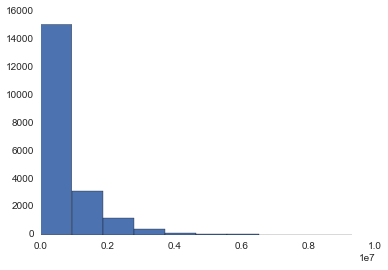

In [381]:
pd.Series(seed[seed < 10000000]).hist()

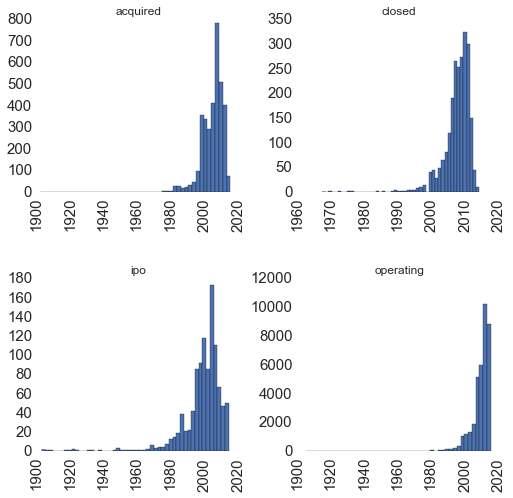

In [649]:
# founded year distributions grouped by company status

companies.hist("founded_year", by = "status", bins = 50, xlabelsize = 15, ylabelsize = 15, figsize = (8,8))
plt.savefig("plot.png")

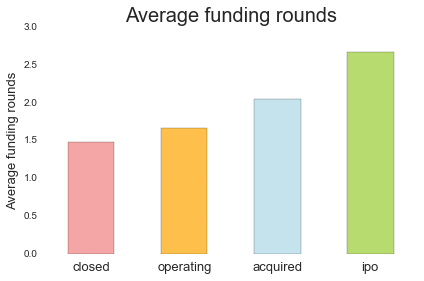

In [107]:
# bar plot of funding rounds

avg_fund_round_plot = companies.groupby("status")["funding_rounds"].mean()
avg_fund_round_plot.sort()

avg_fund_round_plot.plot(kind = "bar", figsize = (6,4), rot = 0, alpha = 0.7, color = ["lightcoral", "orange", "lightblue", "yellowgreen"])
plt.xticks(size = 13)
plt.title("Average funding rounds", size = 20)
plt.xlabel("")
plt.ylabel("Average funding rounds", size = 13)
plt.tight_layout()
plt.savefig("barplot.png")

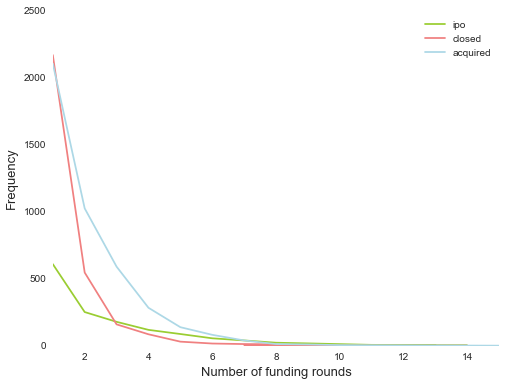

In [109]:
# line graphs of total funding rounds b

closed_funding = companies[companies.status == "closed"]["funding_rounds"].value_counts()
ipo_funding = companies[companies.status == "ipo"]["funding_rounds"].value_counts()
acquired_funding = companies[companies.status == "acquired"]["funding_rounds"].value_counts()

plt.figure(figsize=(8,6))
ipo_funding.plot(color = "yellowgreen")
closed_funding.plot(color = "lightcoral")
acquired_funding.plot(color = "lightblue")
plt.legend(["ipo", "closed", "acquired"])
plt.xlabel("Number of funding rounds", size = 13)
plt.ylabel("Frequency", size = 13)
plt.savefig("funding_round_line.png")

In [119]:
comps_over8_rounds = list(companies[companies.funding_rounds > 8]["name"].apply(lambda x: x.encode('utf-8')))

perm_over8_rounds = []
names = list(companies["name"])
permalinks = list(companies["permalink"])

for comp in comps_over8_rounds:
    try:
        i = names.index(comp)
        a = permalinks[i]
        a = a[14:]
        perm_over8_rounds.append(a)
    except:
        continue

In [539]:
# get 2nd page results that were not picked up the first time

for comp_name in perm_over8_rounds[5:]:
    try:
        api_call = cb.organization(comp_name)
        funding_rounds_summary = api_call.funding_rounds
        more_funding_rounds = cb.more(funding_rounds_summary)
        funding_data = []
        for i in range(len(more_funding_rounds)):
            round_uuid = more_funding_rounds[i].data
            funding_data.append(round_uuid)
        orgs_api.update({"properties.name": comp_name}, {"$set": {"relationships.funding_rounds.items": funding_data}})
    except:
        continue

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221


In [25]:
# find lenghts of descriptions

description_lengths = []
for description in orgs_api.find():
    try:
        desc = description["properties"]["description"]
    except:
        description_lengths.append(0)
        continue
    if hasattr(desc, "lower"):
        description_lengths.append(len(desc))
    else:
        description_lengths.append(0)

In [42]:
plt.hist(description_lengths, bins = 50, range= (0,4000), label="hello")

NameError: name 'description_lengths' is not defined

(array([  277.,   179.,   332.,   380.,   608.,   914.,  1109.,  1155.,
         1078.,  1002.,   758.,   607.,   601.,   689.,   704.,   789.,
          839.,   949.,  1118.,  1211.,  1389.,  1495.,  1718.,  1871.,
         2015.,  2209.,  2259.,  2450.,  2525.,  2669.,  2815.,  3096.,
         3674.,  4775.,  5620.,  1232.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.]),
 array([   0.,    4.,    8.,   12.,   16.,   20.,   24.,   28.,   32.,
          36.,   40.,   44.,   48.,   52.,   56.,   60.,   64.,   68.,
          72.,   76.,   80.,   84.,   88.,   92.,   96.,  100.,  104.,
         108.,  112.,  116.,  120.,  124.,  128.,  132.,  136.,  140.,
         144.,  148.,  152.,  156.,  160.,  164.,  168.,  172.,  176.,
         180.,  184.,  188.,  192.,  196.,  200.]),
 <a list of 50 Patch objects>)

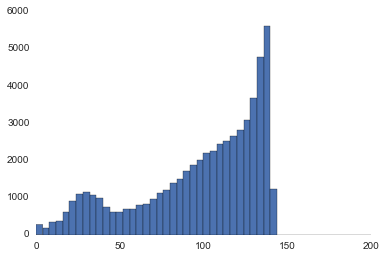

In [40]:
plt.hist(short_description_lengths, bins = 50, range= (0,200))

In [6]:
def get_short_descs():
    list_short_descs = []
    for description in orgs_api.find():
        try:
            short_desc = description["properties"]["short_description"]
        except:
            list_short_descs.append("")
            continue
        if short_desc == None:
            list_short_descs.append("")
        else:
            list_short_descs.append(short_desc)

    def process_descs(desc):
        if desc:
            desc = re.sub(r"[^A-Za-z2]+", ' ', desc)    # keep only letters and numbers
            desc = desc.strip().lower()                 # strip and lowercase
            try:
                desc = desc.split(" ", 1)[1]            # remove company name from description
            except:
                pass
        else:
            desc = "this is a placeholder message. the company did not provide a description"
        return desc
        
    list_short_descs = map(lambda x: process_descs(x), list_short_descs)
    return list_short_descs

In [627]:
def get_raw_short():
    list_short_descs = []
    for description in orgs_api.find():
        try:
            short_desc = description["properties"]["short_description"]
        except:
            list_short_descs.append("")
            continue
        if short_desc == None:
            list_short_descs.append("")
        else:
            list_short_descs.append(short_desc)
    return list_short_descs

raw_short = get_raw_short()

In [7]:
list_short_descs = get_short_descs()

In [140]:
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

def get_stop_words():
    stop_words = stopwords.words("english")
    stop_words.append(["company", "founded", "firm", "800", "offers", "based", "usa", "offering", "inc"])
    for letter in string.ascii_lowercase:
        stop_words.append(letter)
    return stop_words

stop_words = get_stop_words()

tfidf = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, ngram_range=(1, 2))
tfidf.fit(list_short_descs)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'w... 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
        strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x11975c500>, use_idf=True,
        vocabulary=None)

In [137]:
facebook.shape

(1, 233673)

In [141]:
facebook = tfidf.transform(["an online social networking service that enables its users to connect with friends and family as well as make new connections"])

In [142]:
facebook

<1x233673 sparse matrix of type '<type 'numpy.float64'>'
	with 24 stored elements in Compressed Sparse Row format>

In [9]:
descs_tfidf = tfidf.transform(list_short_descs)

In [10]:
def get_properties(key):
    alist = []
    for company in orgs_api.find():
        try:
            alist.append(company["properties"][key])
        except:
            alist.append(np.nan)
    return alist

# founded_on = get_properties("founded_on")
# num_employees_min = get_properties("num_employees_min")
num_employees_max = get_properties("num_employees_max")
primary_role = get_properties("primary_role")
role_investor = get_properties("role_investor")
role_group = get_properties("role_group")
role_school = get_properties("role_school")
# total_funding_usd = get_properties("total_funding_usd")
role_company = get_properties("role_company")
names = get_properties("name")
# homepages = get_properties("homepage_url")

In [11]:
# founded_on = map(lambda x: float(x[:4]) if type(x) == unicode else np.nan, founded_on)
num_employees_max = map(lambda x: float(x) if x else np.nan, num_employees_max)
role_investor = map(lambda x: 1.0 if x else 0.0, role_investor)
role_group = map(lambda x: 1.0 if x else 0.0, role_group)
role_school = map(lambda x: 1.0 if x else 0.0, role_school)
role_company = map(lambda x: 1.0 if x else 0.0, role_company)

imputer = preprocessing.Imputer(strategy = "median")

# founded_on_sparse = imputer.fit_transform(np.array(founded_on)[:, np.newaxis])
# founded_on_sparse = preprocessing.scale(founded_on_sparse)
# founded_on_sparse = sparse.csr_matrix(founded_on_sparse)

num_employees_sparse = imputer.fit_transform(np.array(num_employees_max)[:, np.newaxis])
num_employees_sparse = preprocessing.scale(num_employees_sparse)
num_employees_sparse = num_employees_sparse/10
num_employees_sparse = sparse.csr_matrix(num_employees_sparse)

# total_funding_sparse = imputer.fit_transform(np.array(total_funding_usd)[:, np.newaxis])
# total_funding_sparse = preprocessing.scale(total_funding_sparse)
# total_funding_sparse = total_funding_sparse / 3
# total_funding_sparse = sparse.csr_matrix(total_funding_sparse)

role_investor_sparse = imputer.fit_transform(np.array(role_investor)[:,np.newaxis])
role_investor_sparse = sparse.csr_matrix(role_investor_sparse)

role_group_sparse = imputer.fit_transform(np.array(role_group)[:,np.newaxis])
role_group_sparse = sparse.csr_matrix(role_investor_sparse)

role_school_sparse = imputer.fit_transform(np.array(role_school)[:,np.newaxis])
role_school_sparse = sparse.csr_matrix(role_school_sparse)

role_company = imputer.fit_transform(np.array(role_company)[:,np.newaxis])
role_company_sparse = sparse.csr_matrix(role_company)

primary_role_sparse = sparse.csr_matrix(pd.get_dummies(primary_role))

In [158]:
num_employees_sparse[3].data

array([-0.00356727])

In [510]:
def get_investors():
    alist = []
    for company in orgs_api.find():
        blist = []
        try:
            investors = company["relationships"]["investors"]["items"]
            for investor in investors:
                blist.append(investor["properties"]["name"])
            blist = " ".join(blist)
            alist.append(blist)
        except:
            alist.append("")
    return alist

investors = get_investors()
investors_tfidf = TfidfVectorizer(stop_words = "english")
investors_sparse = investors_tfidf.fit_transform(investors)

In [110]:
def get_hq():
    alist = []
    for company in orgs_api.find():
        try:
            hq = company["relationships"]["headquarters"]["item"]["properties"]["region"]
            if hq == None:
                hq = "NA"
            alist.append(hq)
        except:
            alist.append("NA")
    return alist

headquarters = get_hq()
hq_sparse = sparse.csr_matrix(pd.get_dummies(headquarters))

In [612]:
def get_hq():
    alist = []
    for company in orgs_api.find():
        try:
            city = company["relationships"]["headquarters"]["item"]["properties"]["city"]
            region = company["relationships"]["headquarters"]["item"]["properties"]["region"]
            if not city and not region:
                hq = np.nan
            elif region and not city:
                hq = region
            else:
                hq = city + ", " + region
            alist.append(hq)
        except:
            alist.append(np.nan)
    return alist

hq = get_hq()
# hq_sparse = sparse.csr_matrix(pd.get_dummies(headquarters))

In [611]:
orgs_api.find_one({"properties.name" : "Facebook"})["relationships"]["headquarters"]["item"]["properties"]

{u'city': u'Menlo Park',
 u'city_web_path': u'location/menlo-park/1f8abfef5379b26b702005a09908492f',
 u'country': u'United States',
 u'country_code2': u'US',
 u'country_code3': u'USA',
 u'country_web_path': u'location/united-states/f110fca2105599f6996d011c198b3928',
 u'created_at': 1205362453,
 u'latitude': 37.41605,
 u'longitude': -122.151801,
 u'name': u'Headquarters',
 u'postal_code': u'94025',
 u'region': u'California',
 u'region_code2': u'CA',
 u'region_web_path': u'location/california/eb879a83c91a121e0bb8829782dbcf04',
 u'street_1': u'1601 Willow Road',
 u'street_2': None,
 u'updated_at': 1398138077}

In [12]:
def get_categories():
    alist = []
    for company in orgs_api.find():
        try:
            categories = company["relationships"]["categories"]["items"]
            cat_list = []
        except:
            alist.append("")
            continue
        for category in categories:
            a_category = category["properties"]["name"]
            a_category = a_category.replace(" ", "").replace("-", "").replace("'", "")
            cat_list.append(a_category)
        cat_list = " ".join(cat_list)
        alist.append(cat_list)
    return alist

In [13]:
categories = get_categories()
categories_tfidf = TfidfVectorizer(stop_words = "english")
categories_tfidf.fit(categories)
categories_sparse = categories_tfidf.transform(categories)


In [14]:
# print founded_on.shape
# print num_employees_max.shape
# print primary_role.shape
# print role_investor.shape
# print role_group.shape
# print role_school.shape
# print total_funding_usd.shape
# print role_company.shape
# print investors.shape
# print hq_sparse.shape
# print categories.shape
# print descs_tfidf.shape

combined_sparse = sparse.hstack([num_employees_sparse,
                                 primary_role_sparse,
                                role_investor_sparse,
                                role_group_sparse,
                                role_school_sparse,
                                role_company_sparse,
                                categories_sparse,
                                descs_tfidf])

In [151]:
categories_sparse

<57111x852 sparse matrix of type '<type 'numpy.float64'>'
	with 131415 stored elements in Compressed Sparse Row format>

In [73]:
default_tag = np.array([0,0,1,0,0,0,0,0,0,0,1]).transpose()

In [72]:
default_tag.transpose()

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [111]:
def save_sparse_csr(filename,array):
    np.savez(filename, data = array.data,shape=array.shape)
save_sparse_csr("combined", combined_sparse)

In [116]:
combined_sparse.

<57111x234536 sparse matrix of type '<type 'numpy.float64'>'
	with 1261266 stored elements in COOrdinate format>

In [62]:
role_company_sparse

<57111x1 sparse matrix of type '<type 'numpy.float64'>'
	with 48913 stored elements in Compressed Sparse Row format>

In [18]:
# 57111 x 863
sparse.csr_matrix(default_tag)

NameError: name 'default_tag' is not defined

In [118]:
import cPickle as pickle
import numpy as np
import scipy.sparse

In [92]:
new_fb = sparse.hstack([default_tag , sparse.csr_matrix(np.zeros(shape = (1,852))), facebook])

In [15]:
trunc_algo = TruncatedSVD(n_components = 500)
svd2 = trunc_algo.fit_transform(combined_sparse)

In [17]:
np.save("svd2", svd2)

In [93]:
new_fb2 = trunc_algo.transform(new_fb)

In [94]:
nbrs = NearestNeighbors(algorithm = "brute", metric = "cityblock", n_neighbors = 10)
nbrs.fit(svd)
nbrs.kneighbors(svd[6482])[1]

array([[ 6482, 12494, 12938, 20081, 41924, 46051, 19955, 21945, 43371,
        20926]])

In [95]:
nbrs.kneighbors(new_fb2)

(array([[ 6.98886526,  7.37850043,  7.75568787,  7.75906169,  7.8548777 ,
          7.93942716,  7.95672755,  7.97914752,  8.06934564,  8.09604582]]),
 array([[ 1385, 18468, 11764,  2977, 18493, 48005, 54143,  3384, 48851,
         32051]]))

In [96]:
list_short_descs[18468]

u'is a social network where people connect with each other using exciting features implemented with unique blend of technologies'

In [24]:
list_short_descs[20081]

u'chow holdings provides an online home delivery service of steaks beef meat and wine for households in hong kong'

In [748]:
def get_neighbors(company_name):
    index = names.index(company_name)
    neighbors = nbrs.kneighbors(svd[index])[1][0][1:]
    distances = nbrs.kneighbors(svd[index])[0][0][1:]
    for i in range(len(neighbors)):
        
        status = companies[companies.name == names[neighbors[i]]]["status"].item()
        founded = map(lambda x: int(x) if x>0 else "NA", founded_on)
        
        print "=================================" 
        print "Rank: " + str(i+1) + "   " + "Distance: " + str(round(distances[i], 3))
        print "Company: " + names[neighbors[i]]
        print "Location: " + str(hq[neighbors[i]])
        print "Web Link: " + homepages[neighbors[i]]
        print "Founded: " + str(founded[neighbors[i]])
        print "Total Funding: $" +  "{:,}".format(total_funding_usd[neighbors[i]])
        print "Status: " + status
        print "Categories: " + categories[neighbors[i]]
        print "Description: " + raw_short[neighbors[i]]
        print "\n"

In [34]:
stage = ["Seed", "Angel", "Series A", "Series B", "Series C", "Now"]
companies = ["Company B", "Company A"]
amount = np.array([.325, .7, 4.7, 12, 14, 170])
amount2 = np.array([.7, 0, 4, 0, 0, 0])
df = pd.DataFrame([amount, amount2], columns = stage, index = companies).transpose()

plt.figure(figsize = (10,3.5))

plot = sns.barplot(indexes, amount, color = "blue")
plot.set_ylim(0,15)
sns.set(font_scale = 2)
plot.set_title("Mint vs Wesabe")

mint.set_ylabel("$ million funding")
mint.set_xticklabels(stage)

stage = ["Seed", "Series A", "", "", ""]
indexes2 = np.array([1,2,3,4,5])
amount2 = np.array([.7, 4, 0, 0, 0])

sns.barplot(indexes2, amount2, color = "red")

wesabe.set_ylabel("$ million funding")
wesabe.set_xticklabels(stage)
plt.tight_layout()


NameError: name 'indexes' is not defined

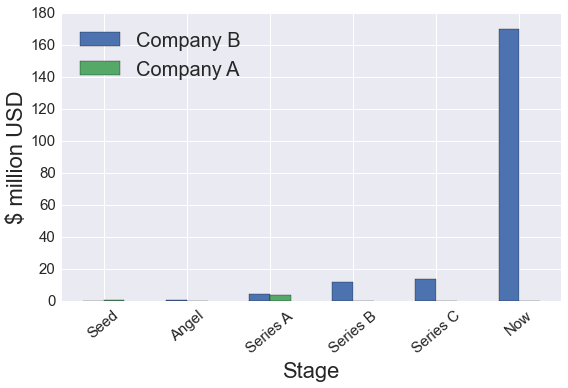

In [60]:
with sns.axes_style("dark"):
    plt.figure(figsize = (10,3.5))
    ax = df.plot(kind = "bar", rot = 40, fontsize = 15)
    ax.set_ylabel("$ million USD")
    ax.set_xlabel("Stage")
    sns.set(font_scale = 1)

    plt.tight_layout()
    plt.savefig("mintwesabe.png")

TypeError: 'str' object is not callable

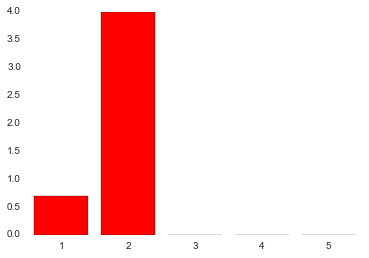

In [49]:
stage = ["Seed", "Series A", "", "", ""]
indexes2 = np.array([1,2,3,4,5])
amount2 = np.array([.7, 4, 0, 0, 0])
sns.barplot(indexes2, amount2, color = "red")
sns.set_style("dark")

In [25]:
np.save("svd", svd)

In [139]:
len(list_short_descs)

57111

In [27]:
with open("shortdescs.txt", "w") as f:
    for item in list_short_descs:
        print>>f, item

In [83]:
a = [1,2,3,4,5]

In [84]:
a.index("hello")

ValueError: 'hello' is not in list

In [90]:
default_tag = np.array([0,0,1,0,0,0,0,0,0,0,1]).transpose()


In [91]:
defaul

(11,)

In [119]:
with open('combined.dat', 'wb') as outfile:
    pickle.dump(combined_sparse, outfile, pickle.HIGHEST_PROTOCOL)

In [19]:
default_tag = np.array([0,0,1,0,0,0,0,0,0,0,1])[np.newaxis, :]
sparse.csr_matrix(default_tag)

<1x11 sparse matrix of type '<type 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [121]:
default_tag.shape

(1, 11)

In [22]:
sparse_matrix = sparse.csr_matrix(np.zeros(shape = (1,852)))

In [24]:
desc_trans = tfidf.transform(["hello my name is dan"])

In [25]:
ew_vec = sparse.hstack([default_tag, sparse_matrix, desc_trans])

In [26]:
ew_vec

<1x234536 sparse matrix of type '<type 'numpy.float64'>'
	with 5 stored elements in COOrdinate format>

In [132]:
combined_sparse.shape

(57111, 234536)

In [135]:
nbrs.kneighbors(trunc_algo.transform(ew_vec))[1][0]

array([ 8318, 15009, 46347,  8438, 35900, 24746, 17434,   335, 45180,  4625])

In [29]:
np.load("combined", combined_sparse)
np.load("shape", )

In [30]:
new_vec = sparse.hstack([default_tag, sparse.csr_matrix(np.zeros(shape = (1,852))), desc_trans])

In [31]:
trunc_vec = trunc_algo.transform(new_vec)

In [40]:
combined_sparse.indptr

AttributeError: indptr not found

In [36]:
combined_sparse.indptr

AttributeError: indptr not found

In [ ]:
shortdescs = map(lambda x: x.encode('utf-8') if x else x, names)